In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [4]:
torch.manual_seed(1111)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

In [7]:
train_set = torchvision.datasets.MNIST(root=".", download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9913344it [00:00, 50368047.09it/s]                             


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


29696it [00:00, 29662789.14it/s]         


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw




1649664it [00:00, 27406866.43it/s]         


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



5120it [00:00, ?it/s]                   

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [8]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        return self.model(x)

In [10]:
discriminator = Discriminator().to(device)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [12]:
generator = Generator().to(device=device)

In [13]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


In [21]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)
        real_samples_labels = torch.ones((batch_size, 1)).to(device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the Discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples.view(-1, 784))
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the Generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device)

        # Training the Generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples.view(-1, 784))
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Print loss
        if n == len(train_loader) - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator.item()}")

Epoch: 0 Loss D.: 0.07808971405029297
Epoch: 0 Loss G.: 5.819380760192871
Epoch: 1 Loss D.: 0.007557641249150038
Epoch: 1 Loss G.: 5.315274715423584
Epoch: 2 Loss D.: 0.029097825288772583
Epoch: 2 Loss G.: 4.693731307983398
Epoch: 3 Loss D.: 0.0010187812149524689
Epoch: 3 Loss G.: 10.307519912719727
Epoch: 4 Loss D.: 0.0006924431072548032
Epoch: 4 Loss G.: 8.423335075378418
Epoch: 5 Loss D.: 0.0
Epoch: 5 Loss G.: 52.182212829589844
Epoch: 6 Loss D.: 1.862645371275562e-09
Epoch: 6 Loss G.: 99.13206481933594
Epoch: 7 Loss D.: 0.0
Epoch: 7 Loss G.: 86.74839782714844
Epoch: 8 Loss D.: 0.0
Epoch: 8 Loss G.: 87.87816619873047
Epoch: 9 Loss D.: 0.0
Epoch: 9 Loss G.: 85.0477523803711
Epoch: 10 Loss D.: 0.0
Epoch: 10 Loss G.: 82.33219146728516
Epoch: 11 Loss D.: 0.0
Epoch: 11 Loss G.: 83.29643249511719
Epoch: 12 Loss D.: 0.0
Epoch: 12 Loss G.: 88.38678741455078
Epoch: 13 Loss D.: 0.0
Epoch: 13 Loss G.: 75.39429473876953
Epoch: 14 Loss D.: 0.0
Epoch: 14 Loss G.: 78.79194641113281
Epoch: 15 Loss 

In [22]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

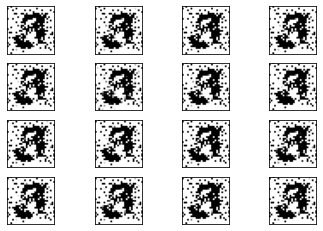

In [23]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])